In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *
from src.agents.supervisor_trader import SupervisorTrader
from src.agents.marginal_agent import MarginalAgent
from src.agents.supervisor_margin_trader import SupervisorMarginTrader
from src.news_providers.tradingview_provider import TradingViewProvider

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

In [2]:
coin = "ETH"

cutoff = get_current_datetime()
str(cutoff)

'2024-05-13 02:41:12.327326'

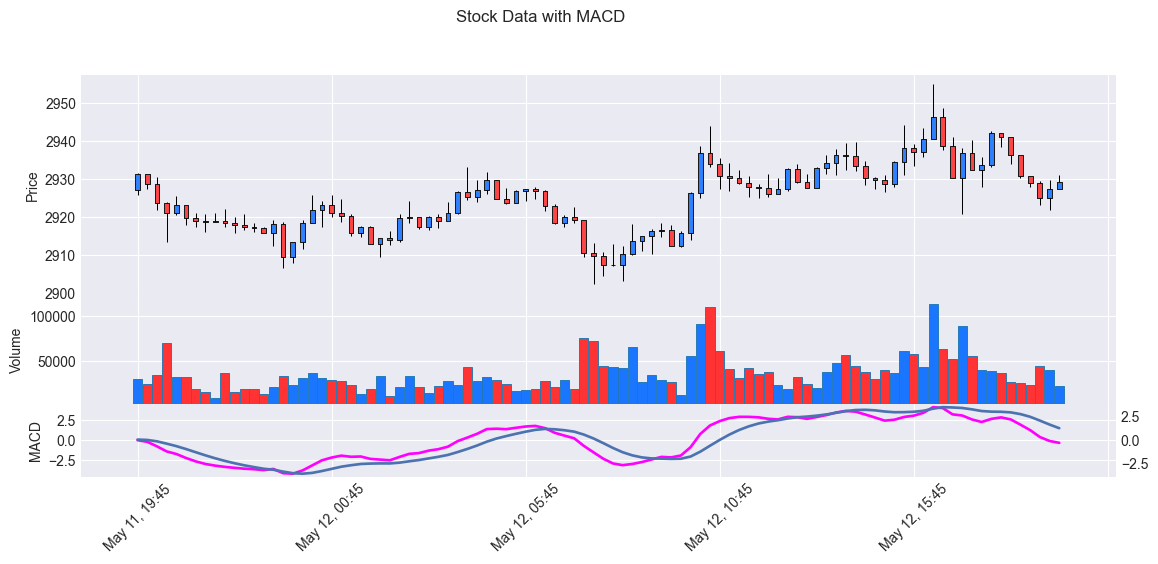

In [3]:
day_12h_history, day_history, week_history = map_async(lambda: get_12h_history(coin), lambda: get_day_history(coin), lambda: get_week_history(coin))
make_candlebars(day_history)

In [19]:
napi = TradingViewProvider()
trading_agent = SupervisorMarginTrader()
filtering_agent = NewsFilteringAgent()

news = napi.get_news(coin)
filtered_news = filtering_agent.filter_news(coin, news[:30])
json.loads(filtered_news)

{'description': "The Ethereum market has experienced several noteworthy developments impacting its valuation and market perception. Firstly, a significant sell-off by a crypto whale led to substantial losses, shedding doubt on the market's short-term prospects. Despite the negative sentiment driven by the sell-off and various reports predicting a price drop to $2,500, Ethereum has shown resilience in daily trading, maintaining a slight price gain. Additionally, the ARK Invest's adjustment to an ETH ETF for removing ETH staking plans suggests a cautious yet strategic approach towards regulatory approval, reflecting sophisticated market adaptation to evolving compliance standards. On the technical front, reported strong correlation with Bitcoin remains as Ethereum’s fundamentals continue to be a subject of scrutiny in broader market dynamics.",
 'sentiment': 'bearish',
 'sentiment_description': 'Despite a slight increase in daily price, the overall sentiment in the Ethereum market leans 

[{'role': 'system', 'content': "You are professional momentum trader with an extensive understanding of cryptocurrency markets. \n                \n                Respond with JSON of described format.\n                Guidelines:\n                - Do not buy on everything you have, distribute spendings!\n                - Consider historical market data and recent news\n                - Use only money from your 'balance'\n                \n                Your goal is to make make as much profit as possible\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last day.'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': 'This is news relevant news and sentiment about ETH. {\n    "description": "The Ethereum market has experienced several noteworthy developments impacting its valuation and market perception. Firstly, a significant sell-off by a crypto whale led to substan
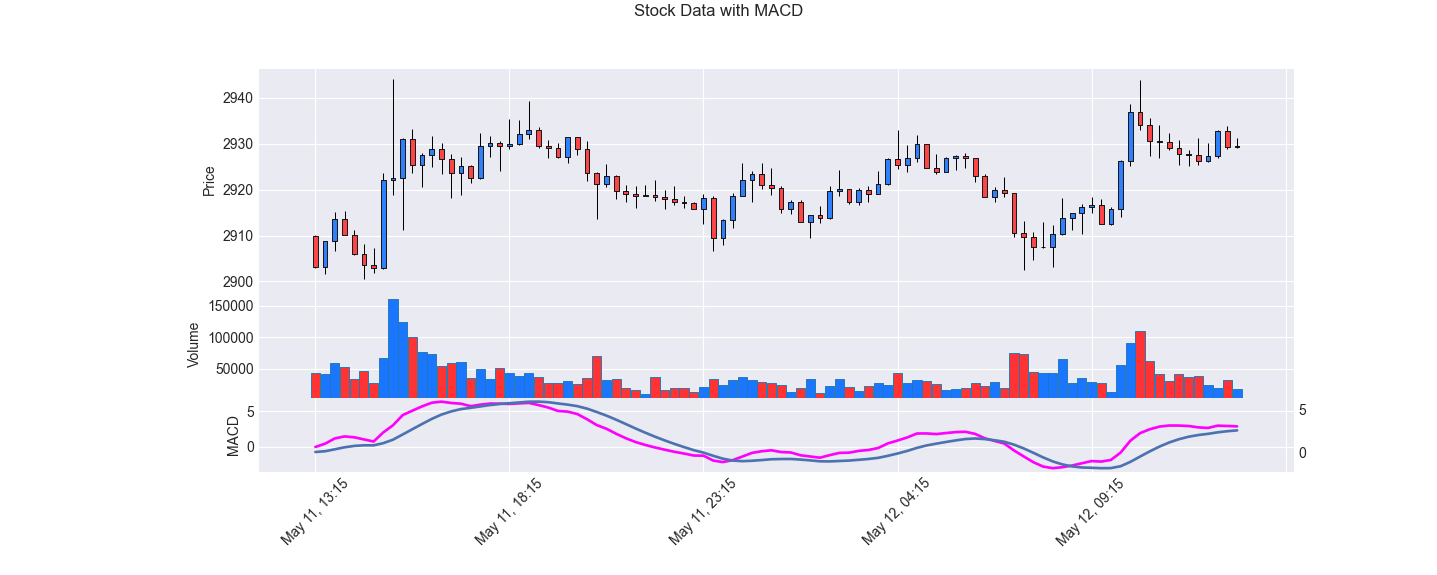

{'strategy_evaluation': 'The short position makes sense given the bearish market sentiment and the lack of strong bullish momentum indicated in the technical analysis. Opening a short position amid bearish news and uncertain, slightly falling MACD signals aligns with a momentum trading strategy aiming to capitalize on potential short-term drops.',
 'calculations_evaluation': 'The profit and loss calculations are correct based on the provided stop-loss and take-profit levels. For the short position, closing at 2900 from 2929.6 offers a potential profit calculation of 1.01%, and a stop-loss at 2950 means a risk of 0.7% loss, both under the given 1x leverage with $1000 capital used.',
 'changes_description': 'No changes to the strategy are required based on the evaluation. The prediction remains aligned with the current market dynamics, both in terms of news analysis and technical indicators.',
 'technical_analysis': 'The MACD on the chart is indicating a slight uptrend with the MACD line

In [20]:
balance = {coin: 0, "USDT": 1000}
operations_history = []

predict, _ = trading_agent.decide(
    coin=coin,
    news=filtered_news,
    #day_12h_data=day_12h_history,
    day_data=day_history,
    #week_data=week_history,
    #year_data=year_history,
    #operations_history=operations_history,
    current_balance=balance,
    leverage="1x",
    verbose=True,
)

result = json.loads(predict)
result

[{'role': 'system', 'content': "You are professional momentum trader with an extensive understanding of cryptocurrency markets. \n                \n                Respond with JSON of described format.\n                Guidelines:\n                - Do not buy on everything you have, distribute spendings!\n                - Consider historical market data and recent news\n                - Use only money from your 'balance'\n                \n                Your goal is to make make as much profit as possible\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last day.'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': "Your current balance, you can only use money that you have:. {'ETH': 0, 'USDT': 1000}"}, {'role': 'user', 'content': 'Decise best actions in the market following momentum trading strategy. Current price: 3479.14.\n\n                Decide what to do in f
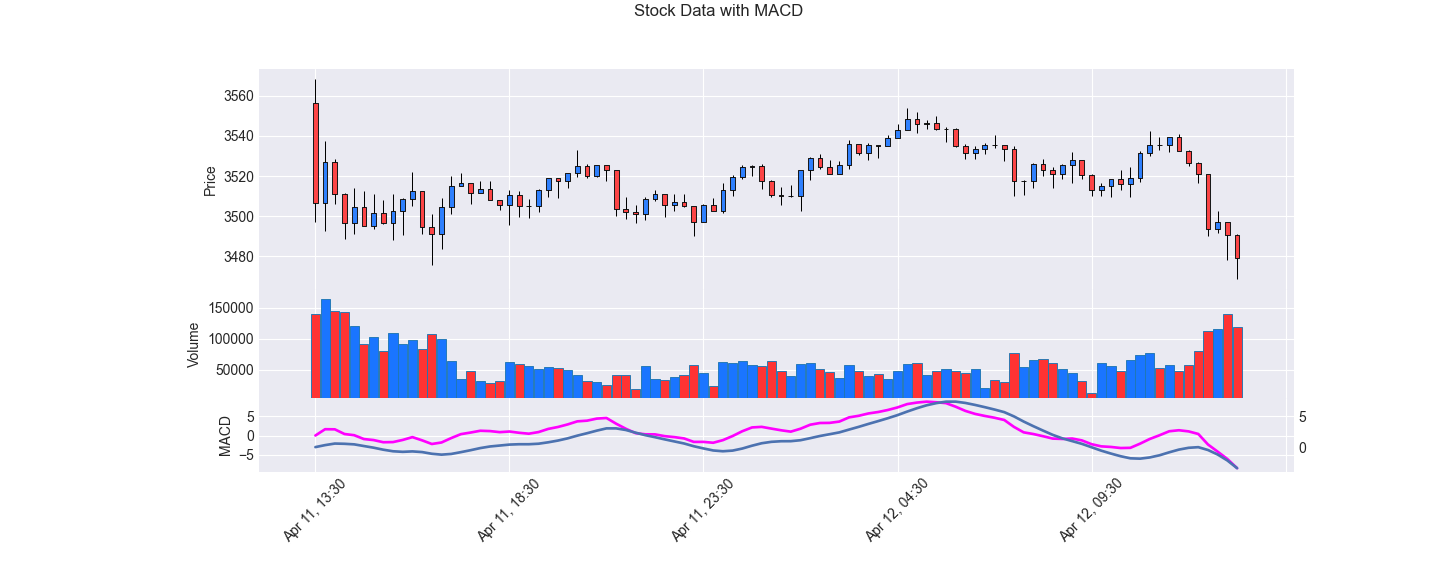

'{\n    "strategy_evaluation": "The strategy to short the market based on current downward momentum and bearish indicators does make sense. The market conditions, including MACD and volume analysis, suggest continuing downward momentum. This approach aligns with the momentum trading strategy, aiming to capitalize on existing market trends rather than predicting turnarounds without significant indicators.",\n    "calculations_evaluation": "The calculations for potential profit and loss percentages are correct. A 3.7% decrease from a position entered at 3479.14 to a take-profit at 3350 adds up correctly, as does a 2% potential loss for the stop-loss at 3550. These calculations align correctly with the price movements and expected market conditions.",\n    "changes_description": "No changes are required in the original strategy or calculations, as the evaluation confirms both the rationale and the math behind the proposed trades are sound.",\n\n    "technical_analysis": "The given MACD ch

In [21]:
from src.agents.automated_supervised_trader import AutomatedSupervisedTrader

agent = AutomatedSupervisedTrader()

cutoff = subtract_time(get_current_datetime(), days=30)

predict, _ = agent.decide(coin=coin, balance=balance, cutoff=cutoff)
predict

In [4]:
from src.testing.test_runner import TestingEngine
from src.agents.random_predictor import RandomPredictor

agent = RandomPredictor(trade_rate=0.04)

engine = TestingEngine(coin = "ETH", agent=agent)

engine.test(balance={"usdt": 1000}, steps=5)

In [5]:
engine.logs

['Start step 0',
 "Predict {'final_decision': 'short', 'price': 3222.21, 'stop_loss': 3286.6542, 'take_profit': 3093.3215999999998, 'leverage': '1x', 'amount': 300.0}",
 "balance {'usdt': 700.0}",
 "MATCHED {'kind': 'short', 'take_profit': 3093.3215999999998, 'stop_loss': 3286.6542, 'amount': 300.0, 'price': 3222.21, 't': 1712950882} SL",
 "new balance {'usdt': 994.0}",
 'Start step 1',
 "Predict {'final_decision': 'short', 'price': 3184.88, 'stop_loss': 3248.5776, 'take_profit': 3057.4848, 'leverage': '1x', 'amount': 298.2}",
 "balance {'usdt': 695.8}",
 "MATCHED {'kind': 'short', 'take_profit': 3057.4848, 'stop_loss': 3248.5776, 'amount': 298.2, 'price': 3184.88, 't': 1712972482} SL",
 "new balance {'usdt': 988.036}",
 'Start step 2',
 "Predict {'final_decision': 'long', 'price': 3259.73, 'stop_loss': 3194.5353999999998, 'take_profit': 3390.1192, 'leverage': '1x', 'amount': 296.4108}",
 "balance {'usdt': 691.6252}",
 "MATCHED {'kind': 'long', 'take_profit': 3390.1192, 'stop_loss': 31

In [110]:


START_DATE = subtract_time(get_current_datetime(), days=30)

current_date = START_DATE

# pending orders
orders = []
balance = {"usdt": 1000}

agent = RandomPredictor(trade_rate=0.04)

logs = []
def process_step():
    if balance["usdt"] < 100:
        return get_day_history(coin, current_date)
    
    predict, _, history = agent.decide(coin=coin, balance=balance, cutoff=current_date)
    
    logs.append(f"Predict {predict}")
    
    final_decision = predict["final_decision"]
    if final_decision != "hold":
        tp = predict["take_profit"]
        sl = predict["stop_loss"]
        amount = predict["amount"]
        price = predict["price"]
        
        new_order = {"kind": final_decision, "take_profit": tp, "stop_loss": sl, "amount": amount, "price": price, "t": get_timestamp(current_date)}
        
        orders.append(new_order)
        
        balance["usdt"] -= amount
    
    logs.append(f"balance {predict}")

    return history

for i in range(STEPS):
    history = process_step()
    

    for idx, order in enumerate(orders):
        amount = order["amount"]
        
        matched, kind, candle_data = match_candle_list(order, history)
        if matched:
            logs.append(f"MATCHED {str(order)} {kind}")
     
            tp_diff, sl_diff = calculate_adjustment(order)
            
            if kind == "TP":
                balance["usdt"] += amount + tp_diff
            if kind == "SL":
                balance["usdt"] += amount + sl_diff
                
            del orders[idx]
            
    current_date = add_time(current_date, hours=INTERVAL_H)
    
print(balance)

{'usdt': 1000}
{'usdt': 700.0}
{'usdt': 1012.0}
{'usdt': 1012.0}
{'usdt': 708.4000000000001}
{'usdt': 1005.9280000000001}
